O conjunto de dados envolve vendas unitárias de 3049 produtos e é classificado em 3 categorias de produtos (Hobbies, Alimentos e Doméstico) e 7 departamentos. 

Os produtos são vendidos em 10 lojas localizadas em 3 estados (CA, TX e WI). 

Os dados vão de 2011-01-29 a 2016-06-19.

Os produtos têm no máximo 1941 dias ou 5,4 anos de dados disponíveis. (O conjunto de dados de teste de 28 dias não está incluído)

O conjunto de dados está dividido em dados de calendário, dados de preço e dados de vendas.

- Dados de calendário: contém colunas, como data, dia da semana, mês, ano e Snap-Days para os estados TX, CA e WI. Além disso, a tabela contém informações sobre feriados e eventos especiais (como Superbowl) por meio de suas colunas event_type1 e event_type2. Os feriados/eventos especiais são divididos em culturais, nacionais, religiosos e esportivos.

- Dados de preço: a tabela consiste nas colunas - loja, item, semana e preço. Ela fornece informações sobre o preço de um item em uma determinada loja, em uma determinada semana.

- Dados de vendas: consiste em arquivos de validação e avaliação. O arquivo de avaliação consiste em vendas por 28 dias extras que podem ser usados ​​para avaliação do modelo. A tabela fornece informações sobre a quantidade vendida de um determinado item em um determinado departamento, em um determinado estado e loja.

In [ ]:
!pip install cufflinks

In [ ]:
import numpy                           as np 
import pandas                          as pd 

import os
import datetime 
import math 
from IPython.display                   import display, HTML

import plotly                          as py
import plotly.graph_objs               as go
import plotly
from plotly.offline                    import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks                       as cf
cf.set_config_file(offline=True)
init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot               as plt
import seaborn                         as sns

from matplotlib                        import pyplot
from statsmodels.tsa.seasonal          import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set(font_scale=1.1)

pd.options.display.float_format = '{:.2f}'.format

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
def anotacao(grafico):
  for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/kaggle/calendar.csv
/content/drive/MyDrive/kaggle/sales_train_evaluation.csv
/content/drive/MyDrive/kaggle/sales_train_validation.csv
/content/drive/MyDrive/kaggle/sample_submission.csv
/content/drive/MyDrive/kaggle/sell_prices.csv


In [ ]:
sales_data = pd.read_csv("/content/drive/MyDrive/kaggle/sales_train_validation.csv")
price_data = pd.read_csv("/content/drive/MyDrive/kaggle/sell_prices.csv")
calendar_data = pd.read_csv("/content/drive/MyDrive/kaggle/calendar.csv")
submission_data = pd.read_csv("/content/drive/MyDrive/kaggle/sample_submission.csv")

In [ ]:
print(f"O DataFrame sales_data tem {sales_data.shape[0]} linhas e {sales_data.shape[1]} colunas")

O DataFrame sales_data tem 30490 linhas e 1919 colunas


In [ ]:
date_col = [col for col in sales_data if col.startswith('d_')]
date_col[:5]

['d_1', 'd_2', 'd_3', 'd_4', 'd_5']

In [ ]:
sales_data['state_id'].value_counts(normalize=True)

CA   0.40
WI   0.30
TX   0.30
Name: state_id, dtype: float64

In [ ]:
sales_data['store_id'].value_counts()

TX_2    3049
WI_3    3049
CA_1    3049
WI_1    3049
TX_1    3049
CA_4    3049
WI_2    3049
TX_3    3049
CA_2    3049
CA_3    3049
Name: store_id, dtype: int64

In [ ]:
sales_data['dept_id'].value_counts(normalize=True)

FOODS_3       0.27
HOUSEHOLD_1   0.17
HOUSEHOLD_2   0.17
HOBBIES_1     0.14
FOODS_2       0.13
FOODS_1       0.07
HOBBIES_2     0.05
Name: dept_id, dtype: float64

In [ ]:
sales_data['cat_id'].value_counts(normalize=True)

FOODS       0.47
HOUSEHOLD   0.34
HOBBIES     0.19
Name: cat_id, dtype: float64

In [ ]:
sales_data['total_sales'] = sales_data[date_col].sum(axis=1)

sales_data.groupby('state_id').agg({"total_sales":"sum"}).reset_index()

,state_id,total_sales
0,CA,28675547
1,TX,18899006
2,WI,18120856


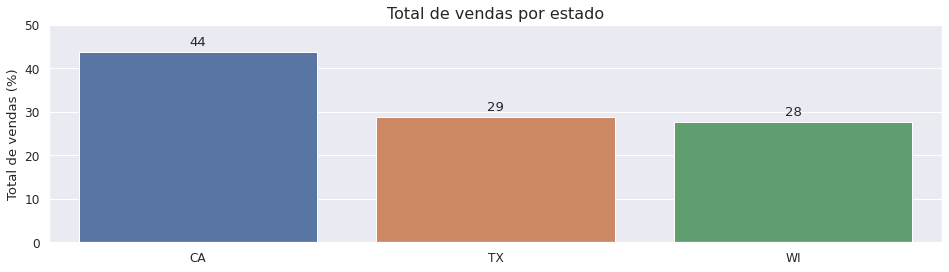

In [ ]:
state_wise_sales_data = sales_data.groupby('state_id').agg({"total_sales":"sum"}) / sales_data['total_sales'].sum() * 100
state_wise_sales_data = state_wise_sales_data.reset_index()

plt.figure(figsize=(16,4))

ax = sns.barplot(data=state_wise_sales_data, x='state_id', y='total_sales')
ax.set_xlabel('')
ax.set_ylabel('Total de vendas (%)')
ax.set_title('Total de vendas por estado', fontsize=16)
ax.set_ylim(0, 50)
anotacao(ax)

plt.show()

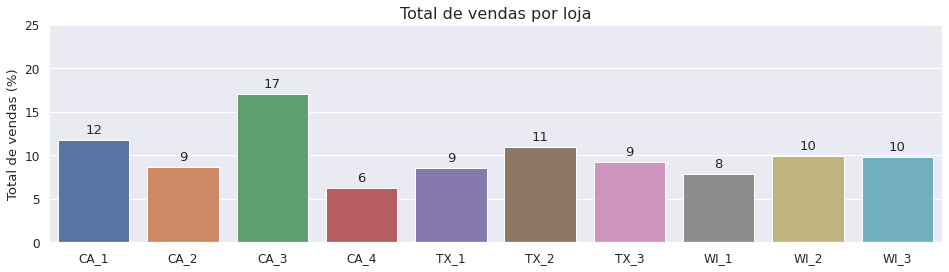

In [ ]:
store_wise_sales_data = sales_data.groupby('store_id').agg({"total_sales":"sum"}) / sales_data.total_sales.sum() * 100
store_wise_sales_data = store_wise_sales_data.reset_index()

plt.figure(figsize=(16,4))

ax = sns.barplot(data=store_wise_sales_data, x='store_id', y='total_sales')
ax.set_xlabel('')
ax.set_ylabel('Total de vendas (%)')
ax.set_title('Total de vendas por loja', fontsize=16)
ax.set_ylim(0, 25)
anotacao(ax)

plt.show()

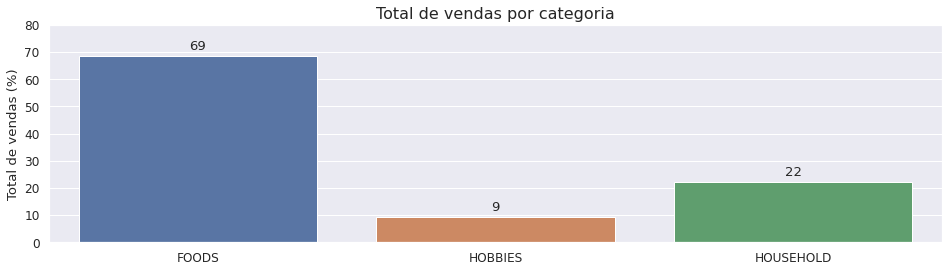

In [ ]:
cat_wise_sales_data = sales_data.groupby('cat_id').agg({"total_sales":"sum"}) / sales_data.total_sales.sum() * 100
cat_wise_sales_data = cat_wise_sales_data.reset_index()

plt.figure(figsize=(16,4))

ax = sns.barplot(data=cat_wise_sales_data, x='cat_id', y='total_sales')
ax.set_xlabel('')
ax.set_ylabel('Total de vendas (%)')
ax.set_title('Total de vendas por categoria', fontsize=16)
ax.set_ylim(0, 80)
anotacao(ax)

plt.show()